In [ ]:
#importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import cv2
import os
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import torchvision.models as models
import torch.optim as optim
from google.colab import files
from torch.optim.lr_scheduler import LambdaLR
import glob
import matplotlib.gridspec as gridspec
import math
import urllib
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Resources:


*   From paper with code: https://github.com/tensorflow/models/tree/master/research/deeplab
*   https://github.com/pytorch/vision/tree/master/torchvision/models/segmentation
* Pytorch's implementation: https://github.com/pytorch/vision/blob/master/torchvision/models/segmentation/deeplabv3.py
* https://github.com/fregu856/deeplabv3
* https://sthalles.github.io/deep_segmentation_network/
* https://github.com/AvivSham/DeepLabv3



## Download data from cityScape


In [ ]:
# !wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=shivam228&password=jain1997&submit=Login' https://www.cityscapes-dataset.com/login/
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
# !wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
# !unzip -qq gtFine_trainvaltest.zip
# !unzip -qq leftImg8bit_trainvaltest.zip

--2021-04-23 04:05:16--  https://www.cityscapes-dataset.com/login/
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cityscapes-dataset.com/downloads/ [following]
--2021-04-23 04:05:17--  https://www.cityscapes-dataset.com/downloads/
Reusing existing connection to www.cityscapes-dataset.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘index.html’

index.html              [  <=>               ]  43.80K   145KB/s    in 0.3s    

2021-04-23 04:05:18 (145 KB/s) - ‘index.html’ saved [44855]

--2021-04-23 04:05:18--  https://www.cityscapes-dataset.com/file-handling/?packageID=1
Resolving www.cityscapes-dataset.com (www.cityscapes-dataset.com)... 139.19.217.8
Connecting to www.cityscapes-dataset.com (www.cityscapes-dataset.com)|139.19.217.8

In [ ]:
# to mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#loading the saved model
ckpt = torch.load('/content/drive/MyDrive/Deeplavv3 PE all material/ckpt-enet-2-567.971449.pth')

In [ ]:
def init_weights(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    m.weight.data.normal_(0.0, .02)
  elif classname.find('BatchNorm') != -1:
    m.weight.data.normal_(1.0, 0.02)
    m.bias.data.constant_(0)

### ResNet-18 pretrained .

In [ ]:
class ResNet_18 (nn.Module):
  def __init__(self, in_channels = 3, conv1_out = 64):
    super(ResNet_18,self).__init__()
    
    self.resnet_18 = models.resnet18(pretrained = True)
    
    self.relu = nn.ReLU(inplace=True)
  
  def forward(self,x):
    x = self.relu(self.resnet_18.bn1(self.resnet_18.conv1(x)))
    x = self.resnet_18.maxpool(x)
    x = self.resnet_18.layer1(x)
    x = self.resnet_18.layer2(x)
    x = self.resnet_18.layer3(x)
    
    return x

Output tensor size check.


In [ ]:
noise = torch.randn(1, 3, 512, 512)
m = ResNet_18()
out = m(noise)
out.shape

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


torch.Size([1, 256, 32, 32])

ASSP block.

In [ ]:
class ASSP(nn.Module):
  def __init__(self,in_channels,out_channels = 256):
    super(ASSP,self).__init__()
    
    
    self.relu = nn.ReLU(inplace=True)
    
    self.conv1 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn1 = nn.BatchNorm2d(out_channels)
    
    self.conv2 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 6,
                          dilation = 6,
                          bias=False)
    
    self.bn2 = nn.BatchNorm2d(out_channels)
    
    self.conv3 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 12,
                          dilation = 12,
                          bias=False)
    
    self.bn3 = nn.BatchNorm2d(out_channels)
    
    self.conv4 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 3,
                          stride=1,
                          padding = 18,
                          dilation = 18,
                          bias=False)
    
    self.bn4 = nn.BatchNorm2d(out_channels)
    
    self.conv5 = nn.Conv2d(in_channels = in_channels, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bn5 = nn.BatchNorm2d(out_channels)
    
    self.convf = nn.Conv2d(in_channels = out_channels * 5, 
                          out_channels = out_channels,
                          kernel_size = 1,
                          stride=1,
                          padding = 0,
                          dilation=1,
                          bias=False)
    
    self.bnf = nn.BatchNorm2d(out_channels)
    
    self.adapool = nn.AdaptiveAvgPool2d(1)  
   
  
  def forward(self,x):
    
    x1 = self.conv1(x)
    x1 = self.bn1(x1)
    x1 = self.relu(x1)
    
    x2 = self.conv2(x)
    x2 = self.bn2(x2)
    x2 = self.relu(x2)
    
    x3 = self.conv3(x)
    x3 = self.bn3(x3)
    x3 = self.relu(x3)
    
    x4 = self.conv4(x)
    x4 = self.bn4(x4)
    x4 = self.relu(x4)
    
    x5 = self.adapool(x)
    x5 = self.conv5(x5)
    x5 = self.bn5(x5)
    x5 = self.relu(x5)
    x5 = F.interpolate(x5, size = tuple(x4.shape[-2:]), mode='bilinear')
    
    #print (x1.shape, x2.shape, x3.shape, x4.shape, x5.shape)
    x = torch.cat((x1,x2,x3,x4,x5), dim = 1) #channels first
    x = self.convf(x)
    x = self.bnf(x)
    x = self.relu(x)
    
    return x

In [ ]:
# Check output size.
noise = torch.randn(2, 3, 32, 32, device=device)
m = ASSP(3).to(device)
out = m(noise)
out.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 256, 32, 32])

## DeepLabv3 block

In [ ]:
class DeepLabv3(nn.Module):
  
  def __init__(self, nc):
    
    super(DeepLabv3, self).__init__()
    
    self.nc = nc
    
    self.resnet = ResNet_18()
    
    self.assp = ASSP(in_channels = 256) #As resnet-18 block gives out-channels =256.
    
    self.conv = nn.Conv2d(in_channels = 256, out_channels = self.nc,
                          kernel_size = 1, stride=1, padding=0)    
    
   
        
  def forward(self,x):
    _, _, h, w = x.shape
    x = self.resnet(x)
    x = self.assp(x)
    x = self.conv(x)
    x = F.interpolate(x, size=(h, w), mode='bilinear') #scale_factor = 16, mode='bilinear')
    return x

In [ ]:
noise = torch.randn(2, 3, 360, 360, device=device)
m = DeepLabv3(12).to(device)
out = m(noise)
out.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([2, 12, 360, 360])

Data loader class.

In [ ]:
def loader(input_path, segmented_path, batch_size, h=1024, w=2048):
    
    filenames = os.listdir(segmented_path)
    total_files = len(filenames)
    
    inp_files = list(map(lambda x : x.split('.')[0] + '.jpg', filenames))
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files
    
    idx = 0
    while(1):
      # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            # Reading normalized photo
            img = np.array(Image.open(input_path + inp_files[jj]))
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            inputs.append(img)
          
            # Reading semantic image
            img = Image.open(segmented_path + filenames[jj])
            img = np.array(img)
            idx255 = img == np.ones_like(img) * 255
            img[idx255] = 0
            # Resizing using nearest neighbor method
            img = cv2.resize(img, (w, h), cv2.INTER_NEAREST)
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
        
        yield inputs, labels

In [ ]:
# Cityscapes dataset Loader

def loader(input_path, segmented_path, batch_size, h=1024, w=2048, limited=False):
    filenames_t = sorted(glob.glob(input_path + '/**/*.png', recursive=True), key=lambda x : int(x.split('/')[-1].split('_')[1] + x.split('/')[-1].split('_')[2]))
    total_files_t = len(filenames_t)
    
    filenames_s = sorted(glob.glob(segmented_path + '/**/*labelIds.png', recursive=True), key=lambda x : int(x.split('/')[-1].split('_')[1] + x.split('/')[-1].split('_')[2]))
    
    total_files_s = len(filenames_s)
    
    assert(total_files_t == total_files_s)
    
    batches = np.random.permutation(np.arange(total_files_s))
    idx0 = 0
    idx1 = idx0 + batch_size
    
    if str(batch_size).lower() == 'all':
        batch_size = total_files_s
    
    idx = 1 if not limited else total_files_s // batch_size + 1
    while(idx):
      
        batch = np.arange(idx0, idx1)
      
        # Choosing random indexes of images and labels
        batch_idxs = np.random.randint(0, total_files_s, batch_size)
        
        inputs = []
        labels = []
        
        for jj in batch_idxs:
            # Reading normalized photo
            img = np.array(Image.open(filenames_t[jj]))
            # Resizing using nearest neighbor method
            inputs.append(img)
          
            # Reading semantic image
            img = Image.open(filenames_s[jj])
            img = np.array(img)
            # Resizing using nearest neighbor method
            labels.append(img)
         
        inputs = np.stack(inputs, axis=2)
        # Changing image format to C x H x W
        inputs = torch.tensor(inputs).transpose(0, 2).transpose(1, 3)
        
        labels = torch.tensor(labels)
       
       
        #print("Inputs shape ", inputs.shape, "labels shape ", labels.shape)
       
        idx0 = idx1 if idx1 + batch_size < total_files_s else 0
        idx1 = idx0 + batch_size
        
        if limited:
          idx -= 1
          
        yield inputs, labels

Setting Parameters and Data path for Train and Test data

In [ ]:

training_path = '/content/drive/MyDrive/Deeplavv3 PE all material/leftImg8bit/train'
segmented_path = '/content/drive/MyDrive/Deeplavv3 PE all material/gtfine/train/'
test_path =   '/content/drive/MyDrive/Deeplavv3 PE all material/leftImg8bit/test/'
segmented_test_path = '/content/drive/MyDrive/Deeplavv3 PE all material/gtfine/test/'
eval_path = '/content/drive/MyDrive/Deeplavv3 PE all material/leftImg8bit/val/'
segmented_eval_path = '/content/drive/MyDrive/Deeplavv3 PE all material/gtfine/val/'
nc = 34
H = 1024
W = 2048
batch_size = 2
train_samples = len(glob.glob(training_path + '/**/*.png', recursive=True))
eval_samples = len(glob.glob(eval_path + '/**/*.png', recursive=True))
test_samples = len(glob.glob(test_path + '/**/*.png', recursive=True))
print("Test samples", test_samples)
print("Train samples", train_samples)
lr = 0.001
epochs = 10
save_every = 1
print_every = 1
eval_every = 1

Test samples 1525
Train samples 2975


To print Images of Test Data

In [ ]:
def show_cscpaes(model, h, w):
  #pipe = loader('./content/imgs/', './content/tregs/', './content/txts/', './content/gt_dst/', 1, h, w)
  inputs, labels = next(test_pipe)
  
  tmg = inputs[0]

  model.eval()
  out = model(tmg.to(device).unsqueeze(0).float())
  model.train()
  
  out2 = out.squeeze(0).cpu().detach().numpy()
  
  plt.title('Input Image')
  plt.axis('off')
  plt.imshow(tmg.transpose(0, 1).transpose(1, 2))
  
  plt.figure(figsize=(10, 10))
  #fig, ax = plt.subplots(nrows=5, ncols=4)
  gs = gridspec.GridSpec(9, 4)
  gs.update(wspace=0.025, hspace=0.0)
  
  label = 0
  for ii in range(34):
    plt.subplot(gs[ii])
    plt.axis('off')
    plt.imshow(out2[label, :, :])
    label += 1
  plt.show()

In [ ]:
def get_class_weights(loader, num_classes, c=1.02):  
    all_labels = []
    
    for _, labels in loader:
      all_labels += list(labels.flatten())
      
    each_class = np.bincount(all_labels, minlength=num_classes)  
    prospensity_score = each_class / len(all_labels)
    class_weights = 1 / (np.log(c + prospensity_score))
    
    return class_weights

In [ ]:
pipe = loader(training_path, segmented_path, batch_size, h = H, w = W)
eval_pipe = loader(eval_path, segmented_eval_path, batch_size, h = H, w = W)
test_pipe = loader(test_path, segmented_test_path, batch_size, h = H, w = W)

In [ ]:
model = DeepLabv3(nc).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)

In [ ]:
#Loading model state
model.load_state_dict(ckpt['state_dict'])

<All keys matched successfully>

In [ ]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: (1 - (epoch / epochs)) ** 0.9)

In [ ]:
all_tests = os.listdir(segmented_path)

#Training and Testing Accuracy

--------------- Epoch 1 ---------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


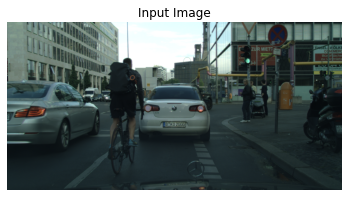

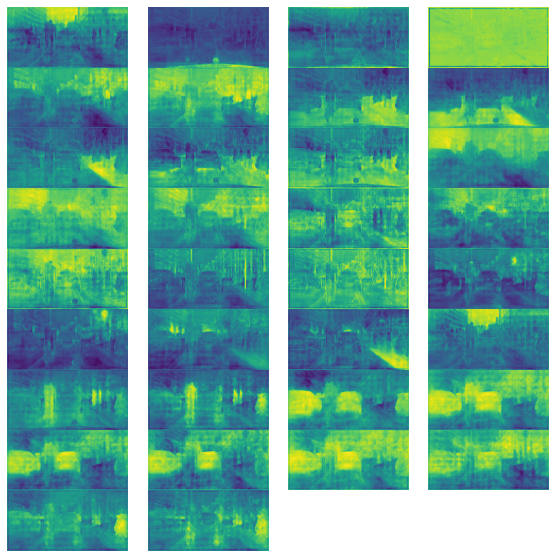

Model saved!


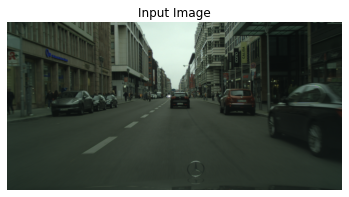

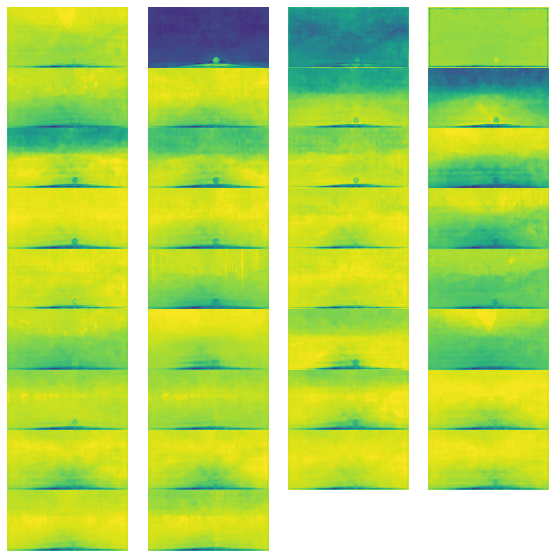

Model saved!


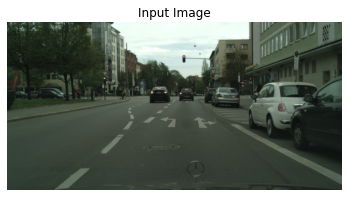

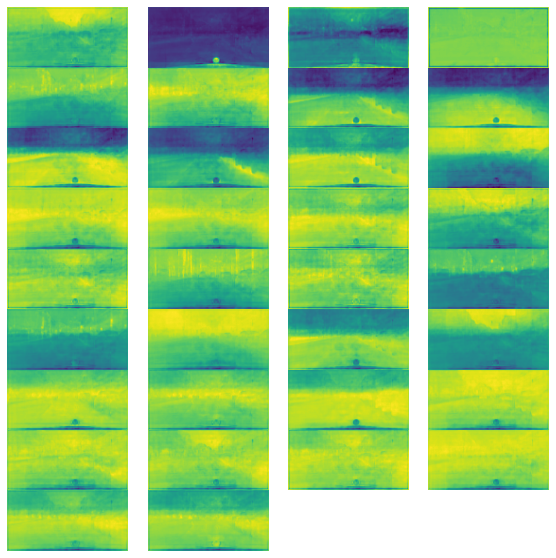

Model saved!


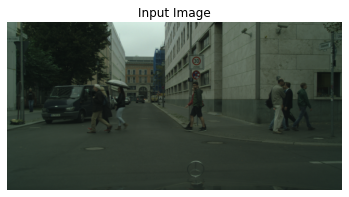

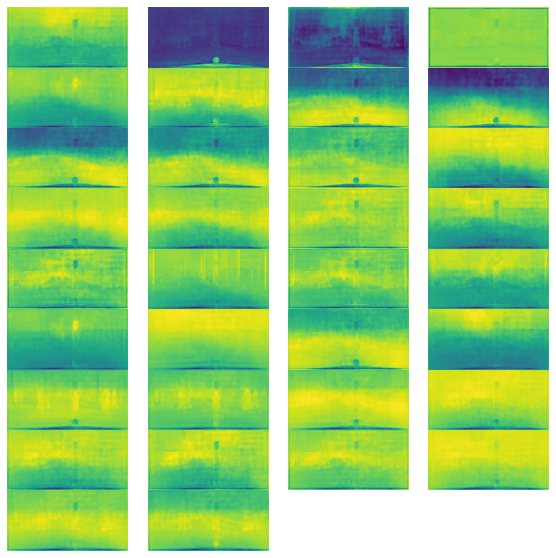

Model saved!


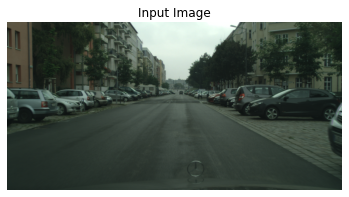

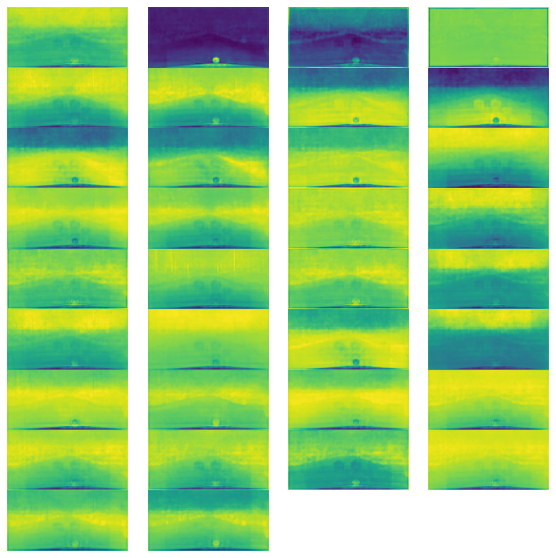

Model saved!


Epoch 1/2... Training Loss 1447.977024 Training accuracy 68.567541


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`




Epoch 1/2... Train Loss 1447.977024
 Test Loss 6483.975653
 Training Accuracy 68.567541
 Test Accuracy 6.324788
Model saved!
--------------- Epoch 2 ---------------


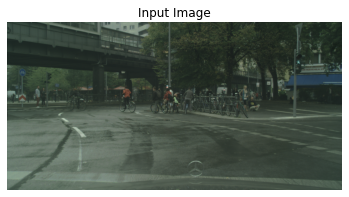

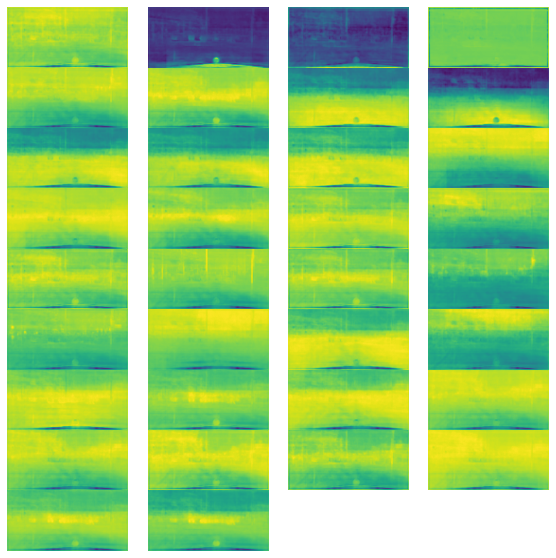

Model saved!


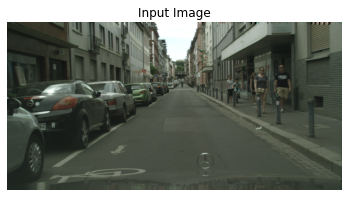

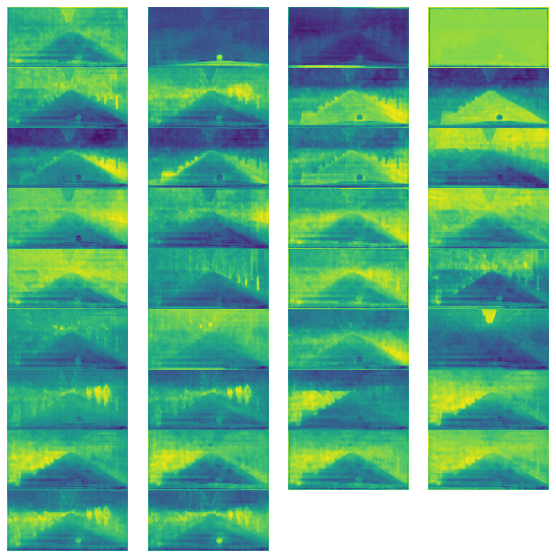

Model saved!


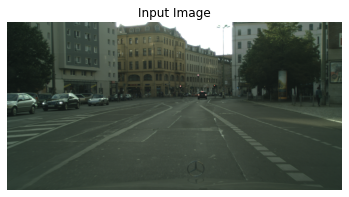

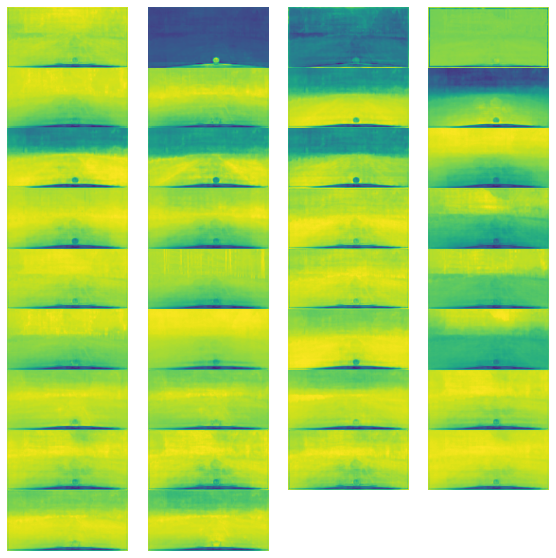

Model saved!


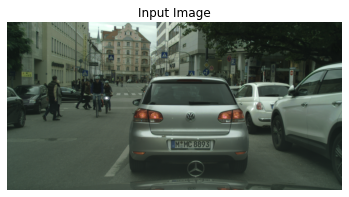

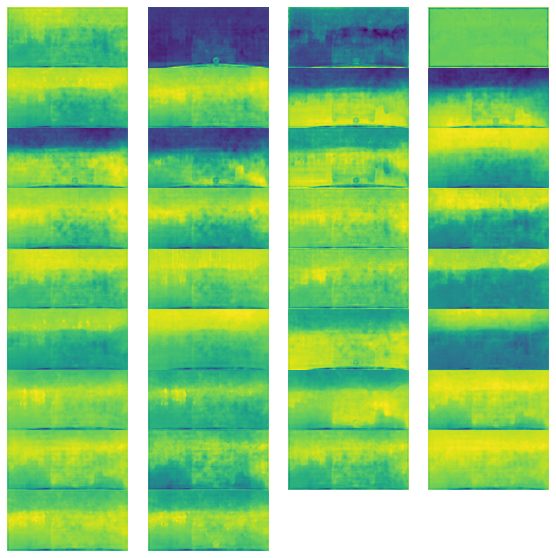

Model saved!


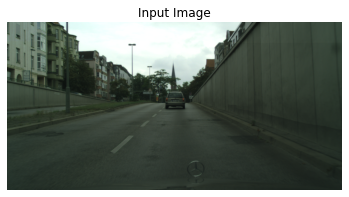

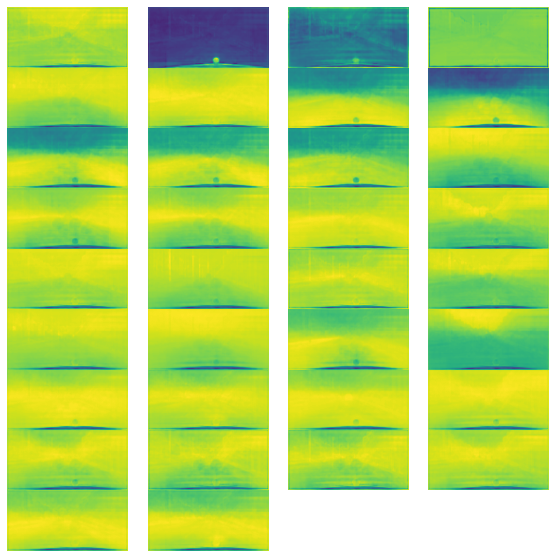

Model saved!


Epoch 2/2... Training Loss 1436.198846 Training accuracy 68.476133




Epoch 2/2... Train Loss 1436.198846
 Test Loss 6938.913095
 Training Accuracy 68.476133
 Test Accuracy 6.365463
Model saved!


In [ ]:
epochs = 2

show_every = 300
total_train =0
correct_train = 0
total_test =0
correct_test = 0
train_losses = []
eval_losses = []

bc_train = train_samples // batch_size
bc_eval = eval_samples // batch_size
bc_test = test_samples // batch_size
for e in range(1, epochs+1):
    train_loss = 0
    print ('-'*15,'Epoch %d' % e, '-'*15)
    #scheduler.step()
    model.train()

    for ii in tqdm(range(bc_train)):
        X_batch, mask_batch = next(pipe)

        X_batch, mask_batch = X_batch.to(device), mask_batch.to(device)

        optimizer.zero_grad()

        out = model(X_batch.float())
        
        loss = criterion(out, mask_batch.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(out.data, 1)
        total_train += mask_batch.nelement()
        correct_train += predicted.eq(mask_batch.data).sum().item()
        train_accuracy = 100 * correct_train / total_train
         

        
        if ii % show_every == 0:
          out5 = show_cscpaes(model, H, W)
          checkpoint = {
              'epochs' : e,
              'model_state_dict' : model.state_dict(),
              'opt_state_dict' : optimizer.state_dict()
          }
          torch.save(checkpoint, './ckpt-dlabv3-{}-{:2f}.pth'.format(e, train_loss))
          print ('Model saved!')

    print ()
    train_losses.append(train_loss)

    if (e+1) % print_every == 0:
        print ('Epoch {}/{}...'.format(e, epochs),
                'Training Loss {:6f}'.format(train_loss),
               'Training accuracy {:6f}'.format(train_accuracy))
    
    if e % eval_every == 0:
        with torch.no_grad():
            model.eval()

            eval_loss = 0

            for _ in tqdm(range(bc_test)):
                inputs, labels = next(test_pipe)

                inputs, labels = inputs.to(device), labels.to(device)
                out = model(inputs.float())

                loss = criterion(out, labels.long())

                eval_loss += loss.item()
                _, predicted = torch.max(out.data, 1)
                total_test += labels.nelement()
                correct_test += predicted.eq(labels.data).sum().item()
                test_accuracy = 100 * correct_test / total_test

            print ()
            print ('Epoch {}/{}...'.format(e, epochs),
                'Train Loss {:6f}'.format(train_loss))
            print (' Test Loss {:6f}'.format(eval_loss))
            print (' Training Accuracy {:6f}'.format(train_accuracy))
            print (' Test Accuracy {:6f}'.format(test_accuracy))

            eval_losses.append(eval_loss)
    
    #scheduler.step(eval_loss)
    
    
    if e % save_every == 0:
        checkpoint = {
            'epochs' : e,
            'state_dict' : model.state_dict()
        }
        torch.save(checkpoint, './ckpt-enet-{}-{:2f}.pth'.format(e, train_loss))
        print ('Model saved!')
        